# 🧪 LAB 4A — Regression Models (Marketing Dataset)
### Bologna Business School — Machine Learning Lab

**Dataset:** `regression_example.csv`

## 🎯 Objectives
- Load, explore, and clean the dataset (handle missing values)
- Visualise predictors vs target and compute correlations
- Univariate linear regression on the strongest predictor
- Multivariate linear regression on all predictors
- Decision Tree regression with cross-validated `max_depth`
- Random Forest regression with cross-validated `max_depth`
- Compare models using RMSE and R²

---

In [1]:
# 🛠️ Environment setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

random_state = 42
np.random.seed(random_state)

---
# PART I — Multivariate Regression (Marketing Dataset)


## 1️⃣ Load the dataset
We load the dataset and inspect the first rows. The target variable is `response`, and the predictors are `F0`–`F7`. The column `idx` is an identifier and will not be used for modelling.

In [2]:
df = pd.read_csv("regression_example.csv")
df.head()

,idx,F0,F1,F2,F3,F4,F5,F6,F7,response
0,0,1.509081,-1.049118,1.978885,1.060733,NaN,0.824655,0.819409,-1.157708,214.593802
1,1,0.644764,0.007172,0.004493,4.168748,-0.622817,1.855366,-0.540468,1.141118,151.951717
2,2,0.890241,1.080162,0.168031,0.002733,0.522478,0.407804,1.629592,-1.102599,117.280863
3,3,-0.212410,-1.034267,1.843441,4.486992,-0.610050,0.734101,-0.142660,-0.172119,229.358473
4,4,-0.827402,-2.048496,-0.066242,1.361695,1.268456,-1.084906,1.986556,0.425511,230.153189


## 2️⃣ Explore the dataset
We examine summary statistics and data types, and we verify whether there are missing values (NaNs).

In [3]:
df.describe()

,idx,F0,F1,F2,F3,F4,F5,F6,F7,response
count,843.000000,802.000000,807.000000,812.000000,8.020000e+02,805.000000,808.000000,806.000000,812.000000,813.000000
mean,421.000000,-0.037473,0.008466,-0.059965,9.616777e-01,-0.093113,0.034653,-0.019928,-0.034976,3.798356
std,243.497433,1.038115,0.973884,0.991280,1.286476e+00,1.050385,0.957238,0.997345,0.963010,114.189124
min,0.000000,-3.700229,-2.832440,-4.141473,2.007427e-08,-4.072767,-2.968219,-2.850505,-3.948627,-358.659591
25%,210.500000,-0.723630,-0.640017,-0.681924,8.725649e-02,-0.802553,-0.625219,-0.689671,-0.662887,-73.823652
50%,421.000000,-0.032953,0.005693,-0.050789,4.707895e-01,-0.090512,0.051123,-0.014592,-0.049392,-0.159154
75%,631.500000,0.629368,0.681480,0.587393,1.350123e+00,0.611545,0.689203,0.612939,0.614423,75.487094
max,842.000000,3.043062,2.945731,2.925432,9.200073e+00,3.024952,3.210373,2.861549,3.000174,422.794685


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843 entries, 0 to 842
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idx       843 non-null    int64  
 1   F0        802 non-null    float64
 2   F1        807 non-null    float64
 3   F2        812 non-null    float64
 4   F3        802 non-null    float64
 5   F4        805 non-null    float64
 6   F5        808 non-null    float64
 7   F6        806 non-null    float64
 8   F7        812 non-null    float64
 9   response  813 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 66.0 KB


## 3️⃣ Handle missing values
Regression estimators in scikit-learn do not accept NaNs by default, so we remove rows containing missing values.

**Note:** In real projects you may consider imputation; here we follow the lab instruction to drop unusable rows.

In [5]:
n_before = df.shape[0]
df_clean = df.dropna()
n_after = df_clean.shape[0]

print(f"Removed {n_before - n_after} rows with missing values")
print("Final shape:", df_clean.shape)

Removed 273 rows with missing values
Final shape: (570, 10)


## 4️⃣ Split into features (X) and target (y)
`idx` is removed because it is an identifier, not a predictive feature.

In [6]:
X = df_clean.drop(columns=["idx", "response"])
y = df_clean["response"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (570, 8)
y shape: (570,)


## 5️⃣ Visual exploration: scatter plots (feature vs target)
These plots provide an initial qualitative understanding of how each feature relates to the target.

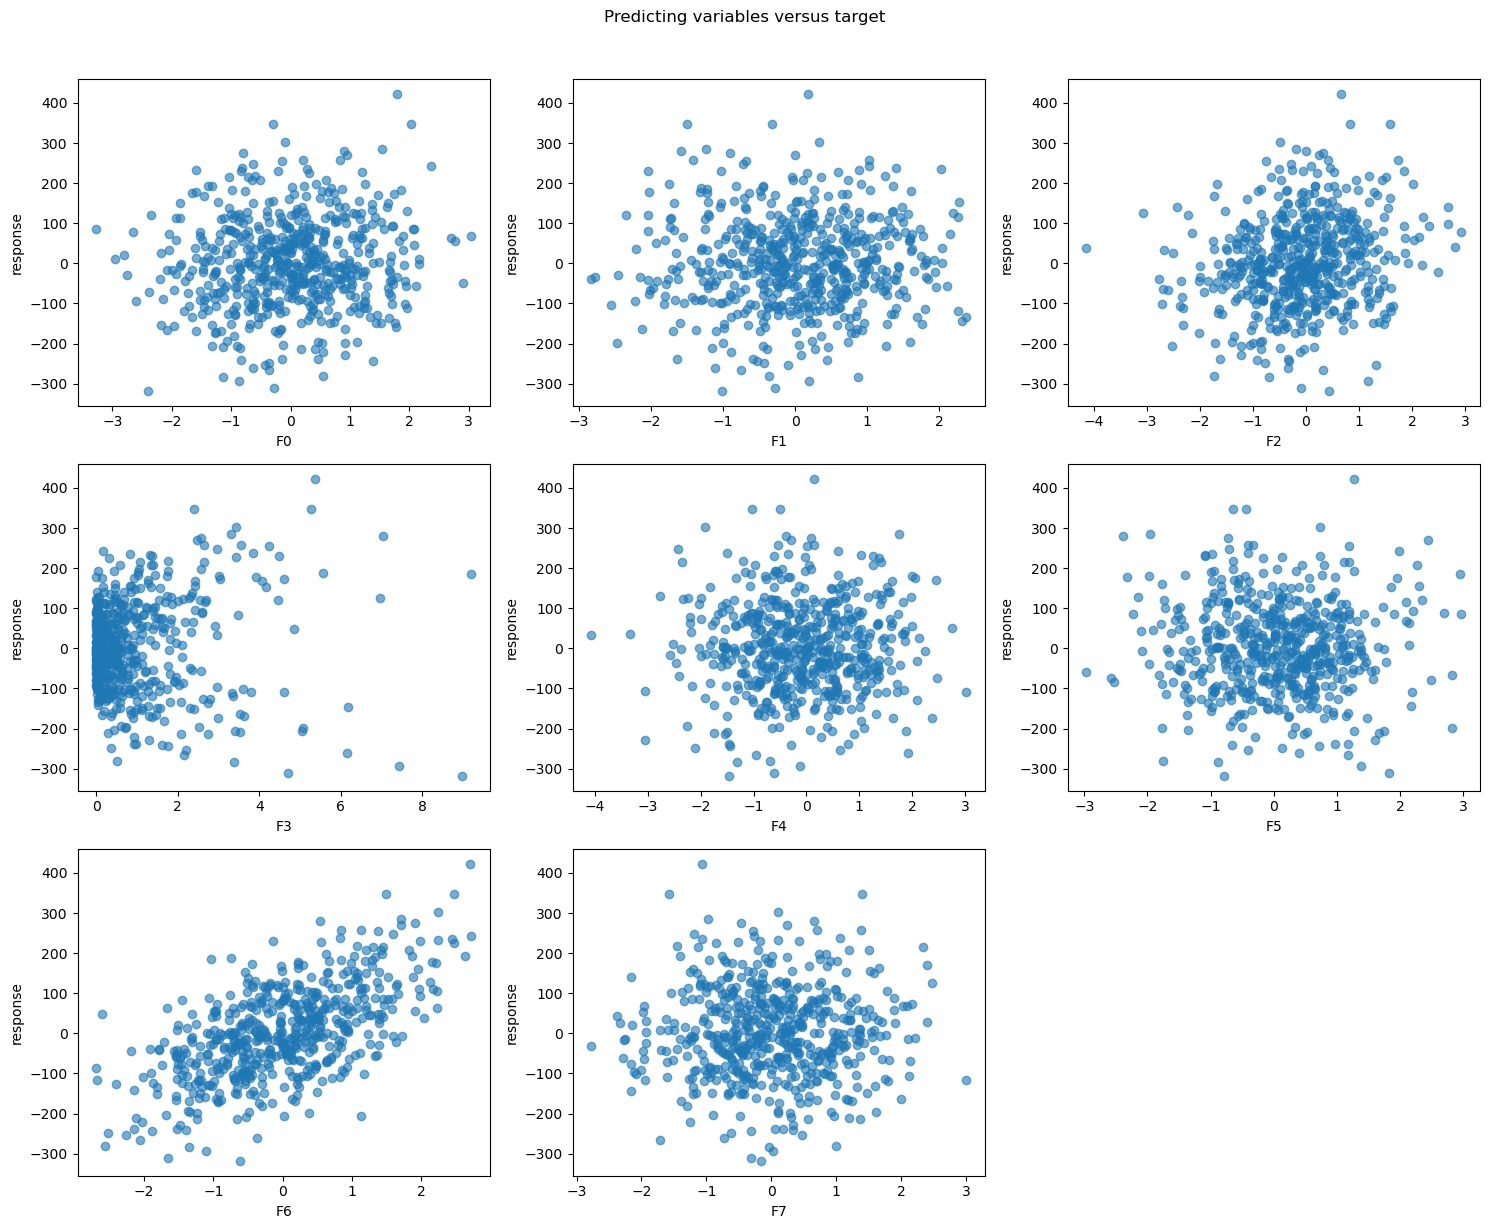

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(X.columns):
    axes[i].scatter(X[col], y, alpha=0.6)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("response")

# Hide the last unused subplot (3x3 grid has 9 slots, we use 8)
axes[-1].axis("off")

plt.suptitle("Predicting variables versus target", y=1.02)
plt.tight_layout()
plt.show()

## 6️⃣ Correlation analysis
We compute the correlation matrix and identify the feature with the highest absolute correlation with the target. This will be used for **univariate linear regression**.

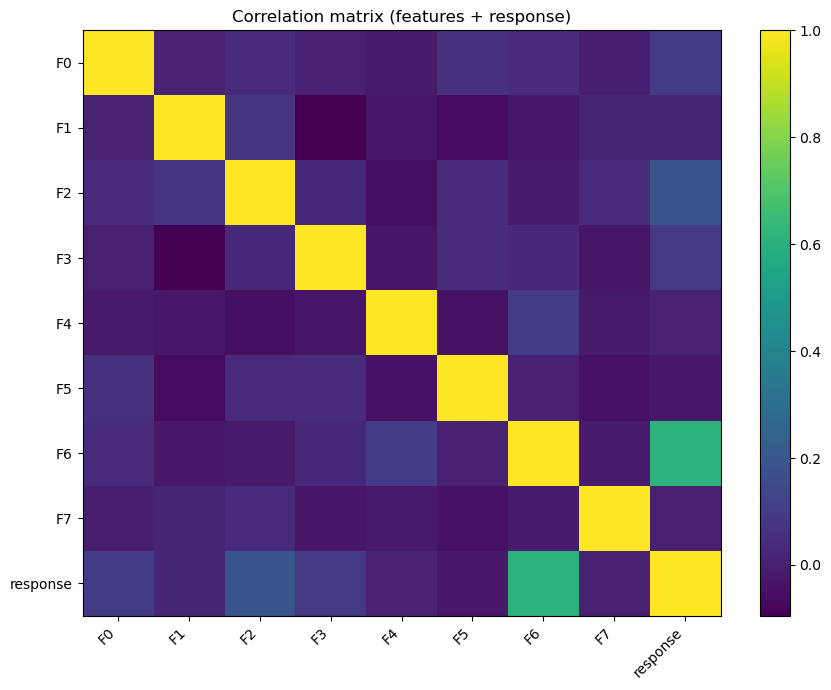

Correlation ranking (by absolute value):


F6    0.613199
F2    0.189681
F0    0.099714
F3    0.085975
F5   -0.021827
F1    0.019469
F4    0.012029
F7    0.002628
Name: response, dtype: float64


Best univariate feature: F6 (corr = 0.6132)


In [8]:
corr = df_clean.drop(columns=["idx"]).corr(numeric_only=True)

plt.figure(figsize=(9, 7))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation matrix (features + response)")
plt.tight_layout()
plt.show()

corr_target = corr["response"].drop("response").sort_values(key=np.abs, ascending=False)
best_feature = corr_target.index[0]

print("Correlation ranking (by absolute value):")
display(corr_target)

print(f"\nBest univariate feature: {best_feature} (corr = {corr_target.iloc[0]:.4f})")

## 7️⃣ Train/test split
We split the dataset into a training set (fit models) and a test set (evaluate generalisation).

**Important:** We set `random_state` for reproducibility.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=random_state
)

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

Training samples: 399
Test samples: 171


---
## 8️⃣ Experiment 1 — Univariate Linear Regression
We fit a linear regression using only the strongest correlated feature (computed above).

In [22]:
X_train_uni = X_train[[best_feature]]
X_test_uni = X_test[[best_feature]]

lin_uni = LinearRegression()
lin_uni.fit(X_train_uni, y_train)

y_pred_uni = lin_uni.predict(X_test_uni)

rmse_uni = np.sqrt(mean_squared_error(y_test, y_pred_uni))
r2_uni = r2_score(y_test, y_pred_uni)

print("Univariate Linear Regression on", best_feature)
print("RMSE:", rmse_uni)
print("R²:", r2_uni)

Univariate Linear Regression on F6
RMSE: 92.3829031294899
R²: 0.4341610926903958


### Optional: statistical significance (simple univariate t-test)
For a single predictor, we can evaluate whether the slope differs significantly from zero. This is a classical OLS-style test (educational).

In [11]:
# Estimate slope standard error for univariate linear regression
x = X_train_uni.values.flatten()
y_tr = y_train.values

# Predictions on training set
y_hat = lin_uni.predict(X_train_uni)
residuals = y_tr - y_hat

n = len(x)
x_mean = x.mean()
Sxx = np.sum((x - x_mean)**2)

# Residual variance estimate (sigma^2)
sigma2 = np.sum(residuals**2) / (n - 2)

# Standard error of slope
se_beta1 = np.sqrt(sigma2 / Sxx)

beta1 = lin_uni.coef_[0]
t_stat = beta1 / se_beta1
p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=n-2))

print("Slope:", beta1)
print("t-statistic:", t_stat)
print("p-value:", p_value)

Slope: 64.51610772536407
t-statistic: 14.362829897392247
p-value: 0.0


---
## 9️⃣ Experiment 2 — Multivariate Linear Regression
We now use all predictors. We inspect coefficients and compute RMSE and R².

In [12]:
lin_multi = LinearRegression()
lin_multi.fit(X_train, y_train)

y_pred_multi = lin_multi.predict(X_test)

rmse_multi = np.sqrt(mean_squared_error(y_test, y_pred_multi))
r2_multi = r2_score(y_test, y_pred_multi)

coef_table = pd.DataFrame({
    "Variable": X.columns,
    "Coefficient": lin_multi.coef_
}).sort_values("Coefficient", key=np.abs, ascending=False)

display(coef_table)

print("Multivariate Linear Regression")
print("RMSE:", rmse_multi)
print("R²:", r2_multi)

,Variable,Coefficient
6,F6,65.397360
2,F2,25.021958
5,F5,-8.718055
4,F4,-8.300362
3,F3,7.808512
0,F0,6.437735
1,F1,3.031226
7,F7,-1.918562


Multivariate Linear Regression
RMSE: 93.24197536459891
R²: 0.42358864706583843


### Cross-validation check (robust comparison)
A single train/test split can be noisy. We estimate average RMSE via 5-fold cross-validation for univariate and multivariate linear models.

In [13]:
cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

scores_uni = cross_val_score(
    LinearRegression(), X[[best_feature]], y,
    scoring="neg_root_mean_squared_error", cv=cv
)
scores_multi = cross_val_score(
    LinearRegression(), X, y,
    scoring="neg_root_mean_squared_error", cv=cv
)

print("CV RMSE (univariate): ", -scores_uni.mean(), "+/-", scores_uni.std())
print("CV RMSE (multivariate):", -scores_multi.mean(), "+/-", scores_multi.std())

CV RMSE (univariate):  90.27967310830968 +/- 3.1146934379090583
CV RMSE (multivariate): 88.66050409950277 +/- 2.9719752867817633


---
## 🔟 Experiment 3 — Decision Tree Regression
We fit a decision tree and tune the `max_depth` hyperparameter using cross-validation.

In [14]:
dt = DecisionTreeRegressor(random_state=random_state)
dt.fit(X_train, y_train)

print("Depth of unconstrained tree:", dt.get_depth())

Depth of unconstrained tree: 24


In [15]:
param_grid = {"max_depth": range(1, 15)}
grid = GridSearchCV(
    DecisionTreeRegressor(random_state=random_state),
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error"
)
grid.fit(X_train, y_train)

best_dt = grid.best_estimator_
print("Best max_depth:", grid.best_params_["max_depth"])

Best max_depth: 2


In [16]:
y_pred_dt = best_dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree (tuned)")
print("RMSE:", rmse_dt)
print("R²:", r2_dt)

Decision Tree (tuned)
RMSE: 96.46498078883452
R²: 0.38305143405466424


### Visualise the tuned decision tree

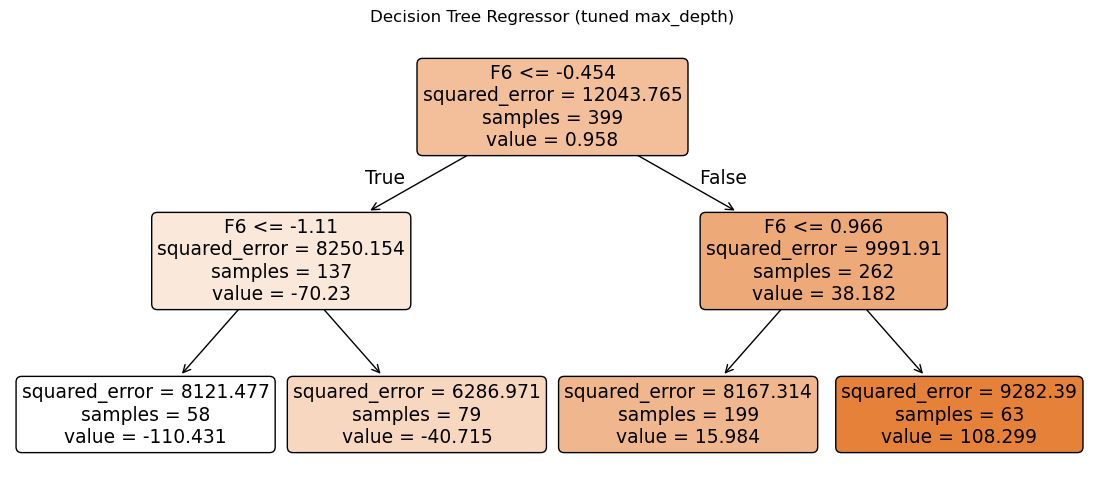

In [17]:
plt.figure(figsize=(14, 6))
plot_tree(best_dt, feature_names=X.columns, filled=True, rounded=True)
plt.title("Decision Tree Regressor (tuned max_depth)")
plt.show()

---
## 1️⃣1️⃣ Experiment 4 — Random Forest Regression
We fit a Random Forest regressor. For simplicity, we tune `max_depth` and keep a moderately large number of trees.

In [18]:
rf_param_grid = {"max_depth": range(1, 11)}
rf_grid = GridSearchCV(
    RandomForestRegressor(n_estimators=200, random_state=random_state),
    rf_param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
print("Best max_depth:", rf_grid.best_params_["max_depth"])

Best max_depth: 2


In [19]:
y_pred_rf = best_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest (tuned)")
print("RMSE:", rmse_rf)
print("R²:", r2_rf)

Random Forest (tuned)
RMSE: 95.98297627018589
R²: 0.3892014183902701


---
## 1️⃣2️⃣ Model comparison (Marketing dataset)
We summarise RMSE and R² for all models and plot predictions vs true values on the test set.

In [20]:
comparison_marketing = pd.DataFrame({
    "Model": [
        f"Linear (univariate: {best_feature})",
        "Linear (multivariate)",
        "Decision Tree (tuned)",
        "Random Forest (tuned)"
    ],
    "RMSE": [rmse_uni, rmse_multi, rmse_dt, rmse_rf],
    "R²": [r2_uni, r2_multi, r2_dt, r2_rf]
})
comparison_marketing

,Model,RMSE,R²
0,Linear (univariate: F6),92.382903,0.434161
1,Linear (multivariate),93.241975,0.423589
2,Decision Tree (tuned),96.464981,0.383051
3,Random Forest (tuned),95.982976,0.389201


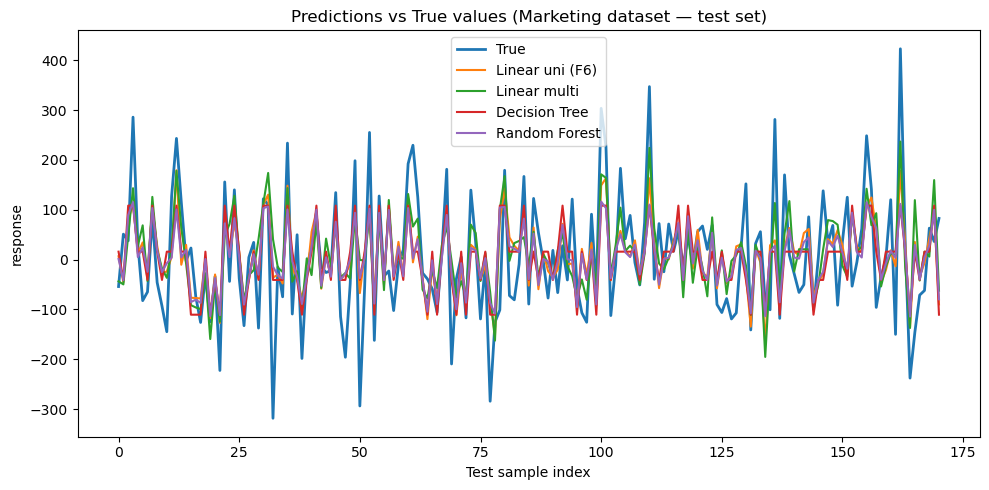

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="True", linewidth=2)
plt.plot(y_pred_uni, label=f"Linear uni ({best_feature})")
plt.plot(y_pred_multi, label="Linear multi")
plt.plot(y_pred_dt, label="Decision Tree")
plt.plot(y_pred_rf, label="Random Forest")
plt.title("Predictions vs True values (Marketing dataset — test set)")
plt.xlabel("Test sample index")
plt.ylabel("response")
plt.legend()
plt.tight_layout()
plt.show()